## FIFA 19 Machine Learning

In [1]:
# import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

## Import Cleaned Data

In [2]:
df = pd.read_csv('cleaned data/fifa19data_clean.csv')
print(df.columns)

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')


In [3]:
df.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,Spain,91,93,Manchester United,72.0,260.0,1471,Right,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102.0,355.0,2281,Right,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


## Feature Engineering

Split the 'Work Rate' feature into 'Attack Work Rate' and 'Defensive Work Rate' and one-hot encode the following categorical features of the dataset:
    - Preferred Foot
    - Attack and Defensive Work Rate
    - Position

In [4]:
# split Work Rate into 2 separate features
df['Attack Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[0], axis=1)
df['Defensive Work Rate'] = df.apply(lambda row: row['Work Rate'].split("/ ")[1], axis=1)

In [5]:
# one-hot encode categorical features
categorical = ['Preferred Foot', 'Attack Work Rate', 'Defensive Work Rate', 'Position']
dummy_prefix = ['Foot', 'AWR', 'DWR', 'Pos']

for i in range(0, len(categorical)):
    df = pd.concat([df, pd.get_dummies(df[categorical[i]], prefix=dummy_prefix[i])], axis=1)

In [6]:
df_dummies = pd.get_dummies(df['International Reputation'])
df_dummies.columns = ['International Reputation'+'_'+str(c) for c in df_dummies.columns]
df= pd.concat([df, df_dummies], axis=1)

In [7]:
#Splitting the columns by position
forward = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
midfielder = ['LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM',  'LDM', 'CDM', 'RDM']
defender = ['LWB', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB']
goalie = ['GK']
npp = ['NP']

In [8]:
#Creating 4 tables respect to positions
df_forward = []
df_midfielder = []
df_defender = []
df_goalie = []
df_np = []
for i in range(0,len(df)):
    for x in npp:
        if df.iloc[i,14]== x:
            df_np.append(df.iloc[i,:])
for i in range(0,len(df)):
    for x in forward:
        if df.iloc[i,14]== x:
            df_forward.append(df.iloc[i,:])
for i in range(0,len(df)):
    for x in midfielder:
        if df.iloc[i,14]== x:
            df_midfielder.append(df.iloc[i,:])
for i in range(0,len(df)):
    for x in defender:
        if df.iloc[i,14]== x:
            df_defender.append(df.iloc[i,:])            
for i in range(0,len(df)):
    for x in goalie:
        if df.iloc[i,14]== x:
            df_goalie.append(df.iloc[i,:])

In [9]:
df_forward = pd.DataFrame(df_forward)
df_midfielder = pd.DataFrame(df_midfielder)
df_defender = pd.DataFrame(df_defender)
df_goalie = pd.DataFrame(df_goalie)
df_np= pd.DataFrame(df_np)
df_forward.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,Pos_RM,Pos_RS,Pos_RW,Pos_RWB,Pos_ST,International Reputation_1.0,International Reputation_2.0,International Reputation_3.0,International Reputation_4.0,International Reputation_5.0
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,...,0,0,0,0,0,0,0,0,0,1
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,...,0,0,0,0,1,0,0,0,0,1
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,...,0,0,0,0,0,0,0,0,0,1
5,E. Hazard,27,Belgium,91,91,Chelsea,93.0,340.0,2142,Right,...,0,0,0,0,0,0,0,0,1,0
7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80.0,455.0,2346,Right,...,0,1,0,0,0,0,0,0,0,1


In [10]:
print (df.shape, df_forward.shape, df_midfielder.shape, df_defender.shape, df_goalie.shape, df_np.shape)

(18159, 120) (3418, 120) (6838, 120) (5866, 120) (2025, 120) (12, 120)


In [15]:
X_columns = list(set(df.columns)-set(['Name', 'Nationality', 'Club','Overall', 'Work Rate','Preferred Foot', 'Attack Work Rate', 'Defensive Work Rate', 'Position']))
y_column = ['Overall']

## Model Training

In [17]:
threshold = 0.8
X_forward = df_forward[X_columns]
X_midfielder = df_midfielder[X_columns]
X_defender = df_defender[X_columns]
X_goalie = df_goalie[X_columns]
X_np = df_np[X_columns]

y_forward = df_forward[y_column]
y_midfielder = df_midfielder[y_column]
y_defender = df_defender[y_column]
y_goalie = df_goalie[y_column]
y_np = df_np[y_column]

X_forward_train, X_forward_test, y_forward_train, y_forward_test = train_test_split(X_forward, y_forward, test_size=1.0-threshold, shuffle=True)
X_midfielder_train, X_midfielder_test, y_midfielder_train, y_midfielder_test = train_test_split(X_midfielder, y_midfielder, test_size=1.0-threshold, shuffle=True)
X_defender_train, X_defender_test, y_defender_train, y_defender_test = train_test_split(X_defender, y_defender, test_size=1.0-threshold, shuffle=True)
X_goalie_train, X_goalie_test, y_goalie_train, y_goalie_test = train_test_split(X_goalie, y_goalie, test_size=1.0-threshold, shuffle=True)
X_np_train, X_np_test, y_np_train, y_np_test = train_test_split(X_np, y_np, test_size=1.0-threshold, shuffle=True)


print('X_forward_train', X_forward_train.shape)
print('y_forward_train', y_forward_train.shape)
print('X_forward_test', X_forward_test.shape)
print('y_forward_test', y_forward_test.shape)

print('X_midfielder_train', X_midfielder_train.shape)
print('y_midfielder_train', y_midfielder_train.shape)
print('X_midfielder_test', X_midfielder_test.shape)
print('y_midfielder_test', y_midfielder_test.shape)

print('X_defender_train', X_defender_train.shape)
print('y_defender_train', y_defender_train.shape)
print('X_defender_test', X_defender_test.shape)
print('y_defender_test', y_defender_test.shape)

print('X_goalie_train', X_goalie_train.shape)
print('y_goalie_train', y_goalie_train.shape)
print('X_goalie_test', X_goalie_test.shape)
print('y_goalie_test', y_goalie_test.shape)

print('X_np_train', X_np_train.shape)
print('y_np_train', y_np_train.shape)
print('X_np_test', X_np_test.shape)
print('y_np_test', y_np_test.shape)

X_forward_train (2734, 111)
y_forward_train (2734, 1)
X_forward_test (684, 111)
y_forward_test (684, 1)
X_midfielder_train (5470, 111)
y_midfielder_train (5470, 1)
X_midfielder_test (1368, 111)
y_midfielder_test (1368, 1)
X_defender_train (4692, 111)
y_defender_train (4692, 1)
X_defender_test (1174, 111)
y_defender_test (1174, 1)
X_goalie_train (1620, 111)
y_goalie_train (1620, 1)
X_goalie_test (405, 111)
y_goalie_test (405, 1)
X_np_train (9, 111)
y_np_train (9, 1)
X_np_test (3, 111)
y_np_test (3, 1)


In [28]:
model_forward= LinearRegression()
model_goalie= LinearRegression()
model_midfielder= LinearRegression()
model_defender= LinearRegression()
model_np= LinearRegression()

model_forward.fit(X_forward_train, y_forward_train)
y_forward_pred = model_forward.predict(X_forward_test)

model_midfielder.fit(X_midfielder_train, y_midfielder_train)
y_midfielder_pred = model_midfielder.predict(X_midfielder_test)

model_defender.fit(X_defender_train, y_defender_train)
y_defender_pred = model_defender.predict(X_defender_test)

model_goalie.fit(X_goalie_train, y_goalie_train)
y_goalie_pred = model_goalie.predict(X_goalie_test)

model_np.fit(X_np_train, y_np_train)
y_np_pred = model_np.predict(X_np_test)

RMSE forward 1.0


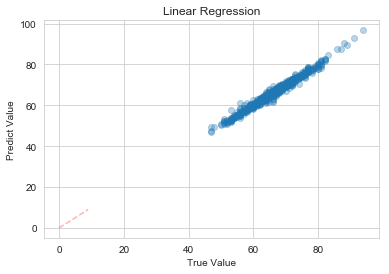

In [24]:
rmse = np.sqrt(mean_squared_error(y_forward_test, y_forward_pred))
print('RMSE forward', round(rmse, 2))
plt.scatter(y_forward_test, y_forward_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE midfielder 1.33


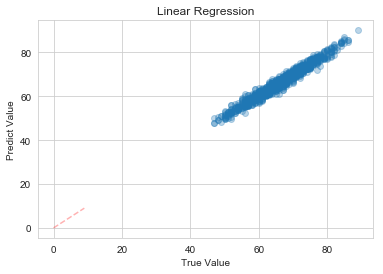

In [25]:
rmse = np.sqrt(mean_squared_error(y_midfielder_test, y_midfielder_pred))
print('RMSE midfielder', round(rmse, 2))
plt.scatter(y_midfielder_test, y_midfielder_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE defender 1.18


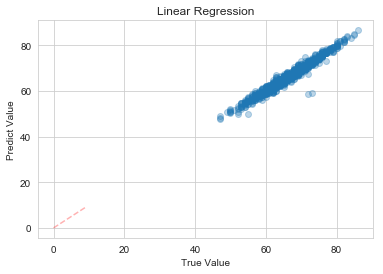

In [26]:
rmse = np.sqrt(mean_squared_error(y_defender_test, y_defender_pred))
print('RMSE defender', round(rmse, 2))
plt.scatter(y_defender_test, y_defender_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE goalie 0.37


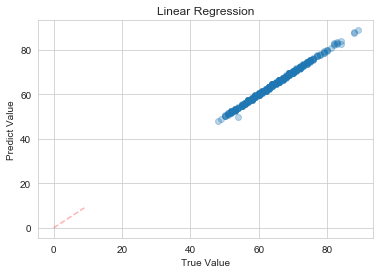

In [29]:
rmse = np.sqrt(mean_squared_error(y_goalie_test, y_goalie_pred))
print('RMSE goalie', round(rmse, 2))
plt.scatter(y_goalie_test, y_goalie_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

RMSE NP 2.12


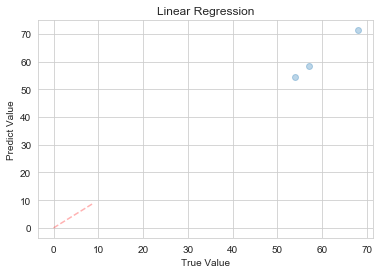

In [30]:
rmse = np.sqrt(mean_squared_error(y_np_test, y_np_pred))
print('RMSE NP', round(rmse, 2))
plt.scatter(y_np_test, y_np_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()